# Homework set 3

(Due Mar 3., 2023 at Noon)

Submit your solution notebook in your directory via github PR.

## Problem 1 (100 pts)

Our Colloquium speaker a couple of weeks ago, Ashley Villar, has had to use MCMC extensively. She had something like 5,243 objects from Pan-STARRS to analyze after all (https://zenodo.org/record/3974950)

You'll only have to deal with two - the two that are in this directory

In [1]:
!ls *snana.dat

PS1_PS1MD_PSc000098.snana.dat PS1_PS1MD_PSc000174.snana.dat


She used equation 1, defined here: https://arxiv.org/abs/1905.07422

# $ F= \begin{cases}\frac{A+\beta\left(t-t_0\right)}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t<t_1 \\ \frac{\left(A+\beta\left(t_1-t_0\right)\right) e^{-\left(t-t_1\right) / \tau_{\text {fall }}}}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t \geq t_1\end{cases} $

to model the *flux*, $F$, of a supernova in some band, at times, $t$.

You can see the fits Ashley derived here:

<img src="examples.jpg">

As Bayesian's we have 4 questions to answer

    What's the model?
    What's the Likelihood?
    What's the Prior?
    How do you sample?

I've tell you 1 (eqn. 1 in Villar). and you've already guessed 4 (use `emcee`: https://emcee.readthedocs.io/en/stable/). 

Write some functions to implement the model, likelihood and priors, and use `emcee` to sample the posterior with 20 walkers and however many steps you feel is necessary for the burn-in and chain. (50 pts - 15 each for the model, likelihood, priors and 5 to sample)
 
Show that the posterior is reasonable by generating a corner plot with the `corner` package. (10 pts)

Get the median estimate for each parameter, and recreate the plot above from Ashley. Note that she's made 5 random draws from the chain for each passband to give the reader a sense for the uncertainties. (25 pts)

Report the auto-correlation length of your chain. Thin it by a factor of 10 and report the auto-correlation length again. (15 pts)

---

In [2]:
import corner
import emcee
import logging
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm
import warnings

<div style="color: DodgerBlue">

I first read the data from the two files and plot the lightcurves for each band to get an idea of what they look like.

</div>

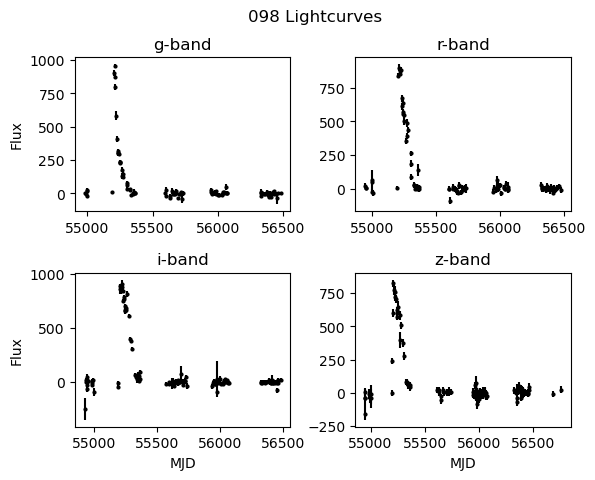

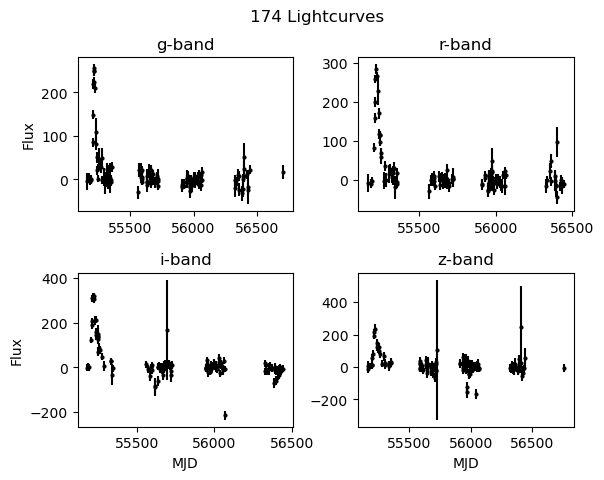

In [3]:
file_098 = 'PS1_PS1MD_PSc000098.snana.dat'
file_174 = 'PS1_PS1MD_PSc000174.snana.dat'


def read_data(file):
    dtype = np.dtype([('t', float), ('band', 'U1'), ('y', float), ('dy', float)])
    data = np.genfromtxt(file, dtype=dtype, skip_header=17, skip_footer=1, usecols=(1, 2, 4, 5))
    data = np.sort(data, order=('band', 't'))
    
    return data


# Plot the lightcurves for each band
def plot_data(data, title):
    fig, axes = plt.subplots(2, 2)
    axes = axes.reshape(axes.size)
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    
    if title is not None:
        fig.suptitle(title)
    
    axes[0].set_ylabel('Flux')
    axes[2].set_ylabel('Flux')
    axes[2].set_xlabel('MJD')
    axes[3].set_xlabel('MJD')
    
    for (ax, band) in zip(axes, 'griz'):
        ax.set_title(f'{band}-band')
        inds = (data['band'] == band)
        t = data[inds]['t']
        y = data[inds]['y']
        dy = data[inds]['dy']
        
        ax.errorbar(t, y, dy, fmt='.', markersize=4, ls='none', c='Black')
    
    plt.show()
    plt.close(fig)
    

data_098 = read_data(file_098)
data_174 = read_data(file_174)
plot_data(data_098, '098 Lightcurves')
plot_data(data_174, '174 Lightcurves')

## Write some functions to implement the model, likelihood and priors, and use `emcee` to sample the posterior with 20 walkers and however many steps you feel is necessary for the burn-in and chain. (50 pts - 15 each for the model, likelihood, priors and 5 to sample)

<div style="color: DodgerBlue">

Here, I implement the model for the flux of the lightcurve as well as the likelihood, prior, and posterior. Some notes about this section:
* The paper includes an additional parameter $c$ to account for a potential offset from 0, but I don't consider this parameter.

* During testing, I noticed that the model would sometimes return `np.nan` due to exponential overflow in both the numerator and denominator. To account for this, I check whether both the numerator and denominator are `np.inf` and, if so, replace the `np.nan`-producing expression.

* I include a `unoise` parameter in the likelihood to account for underestimated uncertainties.

* I assume independent priors and use a modified version of the prior distribution from the paper, described in the following table:  

<center>

| Parameter            | Description      | Prior Distribution                        |
| :------------------: | :--------------: | :---------------------------------------: |
| $A$                  | Amplitude        | $U(3\sigma_{\text{median}},5F_{\text{max}})$              |
| $\beta$              | Plateau slope    | $U(-F_{\text{max}}/150,0)$                |
| $t_{0}$              | Start time       | $U(t_{\text{min}}-50,t_{\text{max}}+300)$ |
| $\gamma$             | Plateau duration | $U(0,200)\cdot(2N(5,5)+N(60,30))/3$       |
| $\tau_{\text{rise}}$ | Rise timescale   | $U(0.01,50)$                              |
| $\tau_{\text{fall}}$ | Fall timescale   | $U(1,300)$                                |

</center>

</div>

In [4]:
ndim = 6


# The given model for lightcurve flux
#        A: amplitude
#     beta: plateau slope
#       t0: start time
#    gamma: plateau duration
# tau_rise: rise timescale
# tau_fall: fall timescale
def model(t, A, beta, t0, gamma, tau_rise, tau_fall):
    t1 = t0 + gamma
    
    # I have to insert some additional logic when t >= t1 since the exponentials can
    # produce np.inf, and np.inf / np.inf == np.nan
    if isinstance(t, (int, float)):
        if t < t1:
            return (A + beta * (t - t0)) / (1 + np.exp(-(t - t0) / tau_rise))
        else:
            num = (A + beta * gamma) * np.exp(-(t - t1) / tau_fall)
            den = 1 + np.exp(-(t - t0) / tau_rise)
            if (abs(num) == den == np.inf):
                return (A + beta * gamma) / (np.exp((t - t1) / tau_fall - (t - t0) / tau_rise))
            else:
                return num / den
    else:
        num = (A + beta * gamma) * np.exp(-(t - t1) / tau_fall)
        den = 1 + np.exp(-(t - t0) / tau_rise)
        tmp = np.where((np.abs(num) == np.inf) & (den == np.inf),
                       (A + beta * gamma) / (np.exp((t - t1) / tau_fall - (t - t0) / tau_rise)),
                       num / den)
        
        result = np.where(t < t1,
                          (A + beta * (t - t0)) / (1 + np.exp(-(t - t0) / tau_rise)),
                          tmp)
        return result


# Assumes squared error loss
def log_likelihood(theta, t, y, dy, unoise=0):
    y_model = model(t, *theta)
    return -np.sum((y - y_model)**2 / (dy**2 + unoise**2) / 2)


# Assume uniform priors on A, beta, t0, tau_rise, tau_fall, with the prior on
# gamma being a sum of Gaussians
def log_prior(theta, t, y, dy):
    A, beta, t0, gamma, tau_rise, tau_fall = theta
    
    t_min = t.min()
    t_max = t.max()
    y_max = y.max()
    sig = np.median(dy)
    
    if (A <= 3 * sig or A >= 5 * y_max) or \
       (beta <= -y_max / 150 or beta >= 0) or \
       (t0 <= t_min - 50 or t0 >= t_max + 300) or \
       (gamma <= 0 or gamma >= 200) or \
       (tau_rise <= 0.01 or tau_rise >= 50) or \
       (tau_fall <= 1 or tau_fall >= 300):
        return -np.inf
    else:
        mu1, sig1 = 5, 5
        mu2, sig2 = 60, 30
        return np.log((2 * norm.pdf(gamma, mu1, sig1) + norm.pdf(gamma, mu2, sig2)) / 3)


def log_posterior(theta, t, y, dy, unoise=0):
    return log_likelihood(theta, t, y, dy, unoise) + log_prior(theta, t, y, dy)

<div style="color: DodgerBlue">

Now I write a function to run the MCMC for a given band.

* I handle the possibility of underestimated uncertainties by comparing the standard deviation and median uncertainty of the continuum flux.

* I obtain an initial estimate of the fit parameters with `scipy.optimize.minimize` and set the initial position of the walkers by perturbing these values. Since this may result in the initial positions being outside of the parameter bounds, I clip the values to within the bounds.

</div>

In [5]:
rng = np.random.default_rng(42)
np.random.seed(42)


def run_mcmc(data, band, nwalkers, nsteps, burnin):
    # Select points in band
    inds = (data['band'] == band)
    t = data['t'][inds]
    y = data['y'][inds]
    dy = data['dy'][inds]
    
    # Handle potentially underestimated uncertainties
    # I picked the cutoff t = 55500 by eye for these two lightcurves, it will not be applicable in a general case
    unoise_inds = (t > 55500)
    unoise = np.sqrt(max(np.std(y[unoise_inds])**2 - np.median(dy[unoise_inds])**2, 0))
    
    # Use scipy.optimize.minimize to produce a preliminary guess of the best-fit model parameters
    # by minimizing the negative log likelihood
    # x0 is chosen from testing and by eye
    x0 = (y.max(), -y.max() / 300, 55210, 10, 0.5, 30)
    bounds = [(3 * np.median(dy), 5 * y.max()),  # A
              (-y.max() / 150, 0),               # beta
              (t.min() - 50, t.max() + 300),     # t_0
              (0, 200),                          # gamma
              (0.01, 50),                        # tau_rise
              (1, 300)]                          # tau_fall
    fit_result = minimize(lambda x, *args: -log_likelihood(x, *args), x0, args=(t, y, dy, unoise), bounds=bounds)
    initial_guess = fit_result.x
    uncertainties = np.sqrt(np.diag(fit_result.hess_inv.todense()))
    initial_state = rng.normal(initial_guess, uncertainties / 5, (nwalkers, ndim))
    
    # Varying the parameters from the initial guess can potentially put the values outside
    # of the valid range, so clip them within bounds
    for i in range(ndim):
        initial_state[:, i] = np.clip(initial_state[:, i], *bounds[i])
    
    # Run MCMC
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(t, y, dy, unoise))
    sampler.random_state = np.random.get_state()
    sampler.run_mcmc(initial_state, burnin)
    sampler.reset()
    sampler.run_mcmc(None, nsteps, progress=True)
    
    return sampler

<div style="color: DodgerBlue">

With all of these functions implemented, I can now run the MCMC. I choose to keep 10000 steps after 1000 initial steps of burn-in. I save the chains as `.npy` files in the `chains` sub-directory.

</div>

In [6]:
nwalkers = 20
nsteps = 10000
burnin = 1000

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    samplers_098 = {band: run_mcmc(data_098, band, nwalkers, nsteps, burnin) for band in 'griz'}
    samplers_174 = {band: run_mcmc(data_174, band, nwalkers, nsteps, burnin) for band in 'griz'}
    
    chains_098 = {band: samplers_098[band].get_chain(flat=True) for band in 'griz'}
    chains_174 = {band: samplers_174[band].get_chain(flat=True) for band in 'griz'}

for band in 'griz':
    np.save(f'chains/098_{band}.npy', chains_098[band])
    np.save(f'chains/174_{band}.npy', chains_174[band])

100%|██████████| 10000/10000 [01:07<00:00, 147.27it/s]


## Show that the posterior is reasonable by generating a corner plot with the `corner` package. (10 pts)

## and

## Get the median estimate for each parameter, and recreate the plot above from Ashley. Note that she's made 5 random draws from the chain for each passband to give the reader a sense for the uncertainties. (25 pts)

<div style="color: DodgerBlue">

Now I write a few functions to visualize the results.

* When comparing the data with the fitted model, I additionally plot the models corresponding to the 5th, 32nd, 68th, and 95th percentiles of each parameter from the sampled posterior distribution to provide an indication of uncertainty in the fit.

</div>

In [7]:
def plot_walkers(chain, title=None, file=None):
    fig, axes = plt.subplots(2, 3)
    axes = axes.reshape(axes.size)
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    
    if title is not None:
        fig.suptitle(title)
    
    labels = ['$A$ (flux)', r'$\beta$ (flux/day)', '$t_{0}$ (days)',
              r'$\gamma$ (days)', r'$\tau_{\rm{rise}}$ (days)', r'$\tau_{\rm{fall}}$ (days)']
    
    for (i, (ax, label)) in enumerate(zip(axes, labels)):
        ax.set_title(label)
        ax.plot(chain[:, i], ls='-', c='Black', marker='.', markersize=2, alpha=0.1)
    
    if file is not None:
        plt.savefig(file)
    else:
        plt.show()
    plt.close(fig)


def plot_corner(chain, title=None, file=None):
    fig = corner.corner(chain,
                        labels=['$A$', r'$\beta$', '$t_{0}$',
                                r'$\gamma$', r'$\tau_{\rm{rise}}$', r'$\tau_{\rm{fall}}$'],
                        plot_contours=True,
                        show_titles=True,
                        smooth=2)
    if title is not None:
        fig.suptitle(title, fontsize=20)
    
    if file is not None:
        plt.savefig(file)
    else:
        plt.show()
    plt.close(fig)


def plot_lightcurve_fit(data, chains, title=None, file=None):
    colors = ('Green', 'Red', 'Orange', 'Purple')
    
    fig, axes = plt.subplots(2, 2)
    axes = axes.reshape(axes.size)
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    
    if title is not None:
        fig.suptitle(title)
    
    axes[0].set_ylabel('Flux')
    axes[2].set_ylabel('Flux')
    axes[2].set_xlabel(r'$t-t_{0,\rm{best}}$')
    axes[3].set_xlabel(r'$t-t_{0,\rm{best}}$')
    
    for (ax, band, color) in zip(axes, 'griz', colors):
        ax.set_title(f'{band}-band')
        inds = (data['band'] == band)
        t = data[inds]['t']
        y = data[inds]['y']
        dy = data[inds]['dy']
        
        params = np.percentile(chains[band], [5, 32, 50, 68, 95], axis=0)
        t0 = params[2, 2]
        t_plot = np.linspace(t.min(), t.max(), 1000)
        
        ax.errorbar(t - t0, y, dy, fmt='.', markersize=2, ls='none', c='Black')
        ax.plot(t_plot - t0, model(t_plot, *params[2, :]), c=color)
        ax.plot(t_plot - t0, model(t_plot, *params[1, :]), c=color, alpha=0.3)
        ax.plot(t_plot - t0, model(t_plot, *params[3, :]), c=color, alpha=0.3)
        ax.plot(t_plot - t0, model(t_plot, *params[0, :]), c=color, alpha=0.3)
        ax.plot(t_plot - t0, model(t_plot, *params[4, :]), c=color, alpha=0.3)
        
        ax.set_xlim(-50, 200)
    
    if file is not None:
        plt.savefig(file)
    else:
        plt.show()
    plt.close(fig)

<div style="color: DodgerBlue">

Create the plots described above for the both objects. These plots are saved to the `plots` sub-directory.

The desired plots are `plots/corner_098_*.png`, `plots/corner_174_*.png`, `plots/fit_098.png`,  and `plots/fit_174.png`.

</div>

In [8]:
for band in 'griz':
    plot_walkers(chains_098[band], f'098 {band}-band Walkers', f'plots/walkers_098_{band}.png')
    plot_walkers(chains_174[band], f'174 {band}-band Walkers', f'plots/walkers_174_{band}.png')

In [9]:
for band in 'griz':
    plot_corner(chains_098[band], f'098 {band}-band Corner Plot', f'plots/corner_098_{band}.png')
    plot_corner(chains_174[band], f'098 {band}-band Corner Plot', f'plots/corner_174_{band}.png')

In [10]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    plot_lightcurve_fit(data_098, chains_098, '098 Lightcurves', 'plots/fit_098.png')
    plot_lightcurve_fit(data_174, chains_174, '174 Lightcurves', 'plots/fit_174.png')

<img src="plots/corner_098_g.png" width="500">
<img src="plots/corner_098_r.png" width="500">
<img src="plots/corner_098_i.png" width="500">
<img src="plots/corner_098_z.png" width="500">

<div style="color: DodgerBlue">

The first thing that stands out to me is that the distribution of $\beta$ for the g-band is nearly uniform, which can indicate that it was not an important parameter in modeling the g-band flux of this object. It is also possible that the distribution peaks outside of the assumed parameter bounds $\beta\in(-F_{\text{max}}/150,0)$, as may be the case for other parameters such as $\beta$ in the r-band and $\tau_{\text{rise}}$ in the i-band.

</div>

<img src="plots/fit_098.png">

<div style="color: DodgerBlue">

These fits appear to match the data quite well.

</div>

<img src="plots/corner_174_g.png" width="500">
<img src="plots/corner_174_r.png" width="500">
<img src="plots/corner_174_i.png" width="500">
<img src="plots/corner_174_z.png" width="500">

<div style="color: DodgerBlue">

Just as in the g-band of the other object, the distributions of $\beta$ for all bands of this object are nearly uniform.

</div>

<img src="plots/fit_174.png">

<div style="color: DodgerBlue">

These lightcurves can also be reconstructed accurately with the model, although the $\pm1\sigma$ and $\pm2\sigma$ models appear to deviate somewhat more visibly from the fitted model for this object than the previous one.

</div>

## Report the auto-correlation length of your chain. Thin it by a factor of 10 and report the auto-correlation length again. (15 pts)

In [11]:
logger = logging.getLogger('emcee.autocorr')
logger.disabled = True

line = ' | '.join(['object', 'band', 'thinned?', 'A'.rjust(6), 'beta'.rjust(6), 't0'.rjust(6), 'gamma'.rjust(6), 't_rise', 't_fall'])
print(line)
print('=' * len(line))
for band in 'griz':
    autocorr         = samplers_098[band].get_autocorr_time(quiet=True)
    autocorr_thinned = samplers_098[band].get_autocorr_time(thin=10, quiet=True)
    
    print(' | '.join(['098'.rjust(6), band.rjust(4), 'n'.rjust(8), *(f'{ac:6.2f}' for ac in autocorr)]))
    print(' | '.join(['098'.rjust(6), band.rjust(4), 'y'.rjust(8), *(f'{ac:6.2f}' for ac in autocorr_thinned)]))
    print('-' * len(line))

for band in 'griz':
    autocorr         = samplers_174[band].get_autocorr_time(quiet=True)
    autocorr_thinned = samplers_174[band].get_autocorr_time(thin=10, quiet=True)
    
    print(' | '.join(['174'.rjust(6), band.rjust(4), 'n'.rjust(8), *(f'{ac:6.2f}' for ac in autocorr)]))
    print(' | '.join(['174'.rjust(6), band.rjust(4), 'y'.rjust(8), *(f'{ac:6.2f}' for ac in autocorr_thinned)]))
    print('-' * len(line))

logger.disabled = False

object | band | thinned? |      A |   beta |     t0 |  gamma | t_rise | t_fall
   098 |    g |        n | 182.06 | 131.53 | 231.38 | 217.60 | 178.97 | 135.86
   098 |    g |        y | 180.89 | 131.55 | 232.48 | 217.30 | 180.26 | 137.80
------------------------------------------------------------------------------
   098 |    r |        n | 150.72 | 147.97 | 249.06 | 201.26 | 155.18 | 114.49
   098 |    r |        y | 149.56 | 147.63 | 247.13 | 201.73 | 154.39 | 115.10
------------------------------------------------------------------------------
   098 |    i |        n |  94.57 |  88.29 |  96.34 |  90.36 | 113.38 |  94.63
   098 |    i |        y |  94.69 |  88.37 |  96.75 |  91.04 | 113.96 |  95.17
------------------------------------------------------------------------------
   098 |    z |        n |  72.31 |  69.03 |  67.35 |  71.94 |  73.63 |  80.24
   098 |    z |        y |  73.73 |  70.34 |  67.50 |  72.51 |  74.45 |  80.97
----------------------------------------------------

<div style="color: DodgerBlue">

Thinning the chain by a factor of 10 does not seem to affect the autocorrelation length as reported by `emcee.EnsembleSampler.get_autocorr_time`. This could mean that the chain is not long enough to report an accurate autocorrelation time or that the chain would need to be thinned by more than this amount to significantly reduce autocorrelation.

</div>